
--- 1. DATA PREPARATION & FORENSICS ---
  > Theoretical Box: 121 Lat x 121 Lon = 14641 Pixels
  > Actual Land Pixels (UK Only): 3104 (21.2% of box)

--- 2. PHYSICS PROCESSING (Sum vs Mean) ---

--- 3. SETUP & SPLIT ---
  > Features used for ML: ['t2m', 'skt', 'stl1', 'swvl1', 'sde', 'tp', 'e', 'ro', 'sf', 'ssrd']
  > Train Shape: (167616, 10) | Test Shape: (55872, 10)

--- 4. HYPERPARAMETER OPTIMIZATION (Random Search) ---
  > Testing 20 combinations with 5-Fold CV... (This takes a moment)
Fitting 5 folds for each of 20 candidates, totalling 100 fits
  > Best Accuracy (CV): 0.8671
  > Best Params: {'l2_regularization': np.float64(0.23338144662398996), 'learning_rate': np.float64(0.26798212202089616), 'max_depth': 25, 'max_iter': 940, 'min_samples_leaf': 58}

--- 5. FINAL EVALUATION ---
  > Accuracy (Train): 0.942923
  > Accuracy (Test):  0.873586
  > 95% Conf. Int.:   0.7394 ± 0.1244


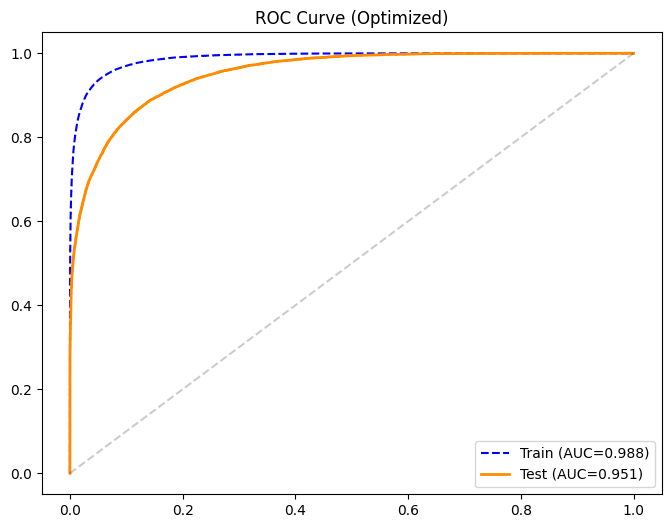


Generating Histogram with detailed statistics...


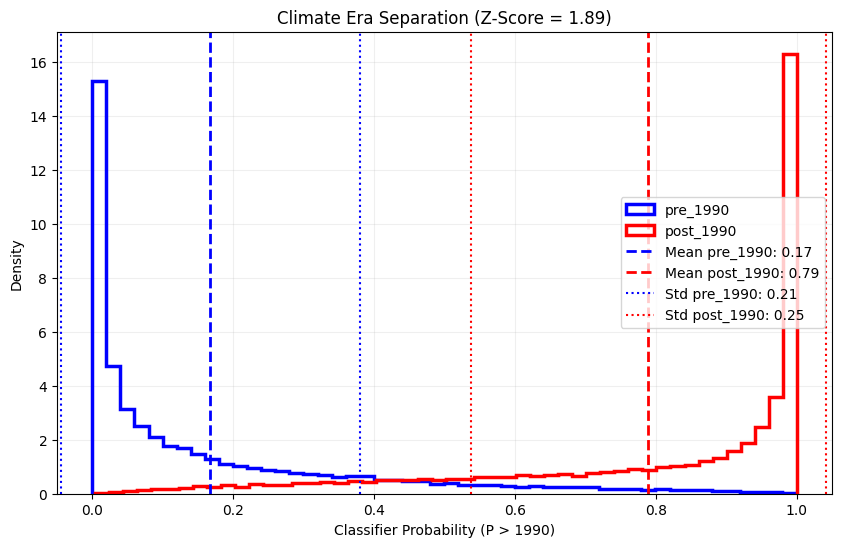

Calculating feature importance...


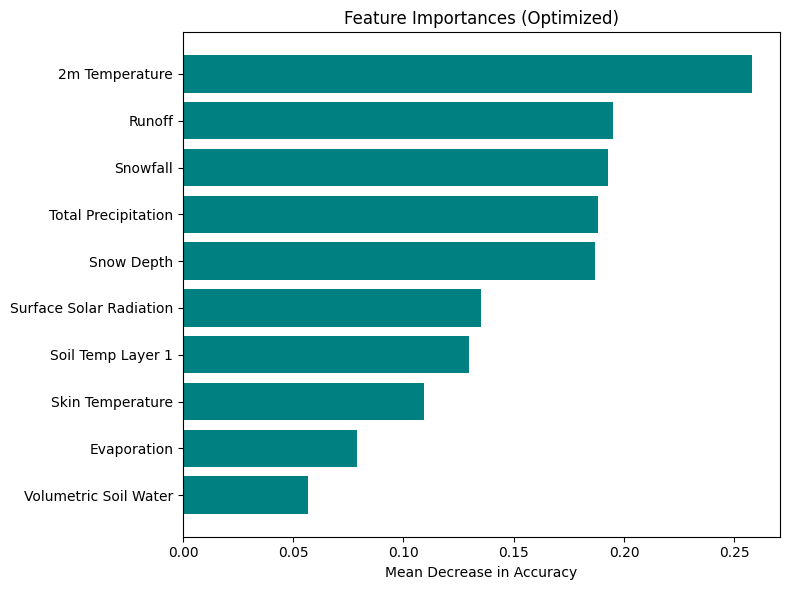

Generating Confusion Matrix...


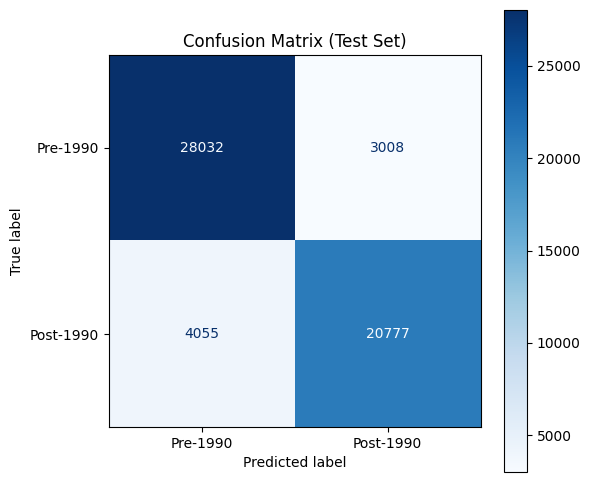


--- PIPELINE COMPLETE ---


In [9]:
# ==============================================================================
# MASTER CLIMATE PIPELINE: Optimized Physics + Hyperparam Search + Strict Plots
# ==============================================================================
# 1. Loads Data & Diagnostic Checks (Box Size, Columns).
# 2. Masks Strict UK (Removes Ireland/Ocean).
# 3. Physics Logic: Fluxes (Sum) vs States (Mean).
# 4. RandomizedSearchCV: Finds best Hyperparameters.
# 5. Visuals: ROC + Histogram + Feature Importance + CONFUSION MATRIX.
# ==============================================================================

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regionmask
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import (roc_curve, auc, confusion_matrix, classification_report, ConfusionMatrixDisplay)
from scipy.stats import sem, t, uniform, randint
import os

# ---------------------------
# 1. User Settings
# ---------------------------
file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/11variables.nc'
out_folder = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/ml_outputs_optimized'
os.makedirs(out_folder, exist_ok=True)

# Map for pretty printing
var_map = {
    't2m': '2m Temperature', 'skt': 'Skin Temperature', 'stl1': 'Soil Temp Layer 1',
    'swvl1': 'Volumetric Soil Water', 'sde': 'Snow Depth', 'tp': 'Total Precipitation',
    'e': 'Evaporation', 'ro': 'Runoff', 'sf': 'Snowfall', 'ssrd': 'Surface Solar Radiation'
}
vars_10 = list(var_map.keys())

# ---------------------------
# 2. Data Loading & Forensics
# ---------------------------
print("\n--- 1. DATA PREPARATION & FORENSICS ---")
ds = xr.open_dataset(file_path)

# Define Bounding Box
N, S, E, W = 61, 49, 2, -10
uk_box = ds.sel(latitude=slice(N, S), longitude=slice(W, E)).rename({'longitude': 'lon', 'latitude': 'lat'})

# Diagnostic: Theoretical Box Size
n_lat, n_lon = len(uk_box.lat), len(uk_box.lon)
print(f"  > Theoretical Box: {n_lat} Lat x {n_lon} Lon = {n_lat*n_lon} Pixels")

# Apply Strict UK Mask
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
uk_index = countries.names.index('United Kingdom')
mask = countries.mask(uk_box['lon'], uk_box['lat']) == uk_index
uk_masked = uk_box.where(mask)

# Diagnostic: Actual Land Pixels
sample_slice = uk_masked['t2m'].isel(valid_time=0)
n_land = int(sample_slice.count().values)
print(f"  > Actual Land Pixels (UK Only): {n_land} ({(n_land/(n_lat*n_lon))*100:.1f}% of box)")

# ---------------------------
# 3. Physics Processing
# ---------------------------
print("\n--- 2. PHYSICS PROCESSING (Sum vs Mean) ---")
time_coord = 'valid_time' if 'valid_time' in uk_masked.coords else list(uk_masked.coords)[0]
days = uk_masked[time_coord].dt.days_in_month
days_3d = days.broadcast_like(uk_masked['t2m'])

yearly_das = []
for v in vars_10:
    da = uk_masked[v]
    
    # CASE 1: Fluxes (Rain, Evap, Runoff, Snowfall) -> SUM over year
    if v in ['tp', 'e', 'ro', 'sf']: 
        yearly_da = (da * days_3d).groupby(uk_masked[time_coord].dt.year).sum(dim=time_coord) * 1000.0
        
    # CASE 2: Energy (Solar) -> SUM over year (Joules)
    elif v == 'ssrd':
        yearly_da = da.groupby(uk_masked[time_coord].dt.year).sum(dim=time_coord)
        
    # CASE 3: States (Temp, Soil, Snow Depth) -> MEAN over year
    else: 
        yearly_da = da.groupby(uk_masked[time_coord].dt.year).mean(dim=time_coord)
        if v in ['t2m', 'skt', 'stl1']: yearly_da -= 273.15
            
    yearly_da.name = v
    yearly_das.append(yearly_da)

df = xr.merge(yearly_das).to_dataframe().reset_index().dropna(how='any').reset_index(drop=True)
df = df[df['year'] < 2022] # Strict filter before 2022

# ---------------------------
# 4. Feature Setup & Split
# ---------------------------
print("\n--- 3. SETUP & SPLIT ---")
df['target'] = (df['year'] >= 1990).astype(int)

# Column Detective
feature_cols = [c for c in df.columns if c not in ['year', 'target', 'lat', 'lon', 'number']]
print(f"  > Features used for ML: {feature_cols}")

X = df[feature_cols].values
y = df['target'].values

# Split Ratio: 75/25
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print(f"  > Train Shape: {X_train.shape} | Test Shape: {X_test.shape}")

# ---------------------------
# 5. Hyperparameter Optimization
# ---------------------------
print("\n--- 4. HYPERPARAMETER OPTIMIZATION (Random Search) ---")
print("  > Testing 20 combinations with 5-Fold CV... (This takes a moment)")

param_dist = {
    'learning_rate': uniform(0.01, 0.3),
    'max_iter': randint(100, 1000),
    'max_depth': [None, 10, 15, 20, 25],
    'min_samples_leaf': randint(20, 100),
    'l2_regularization': uniform(0, 0.5)
}

base_clf = HistGradientBoostingClassifier(random_state=42, early_stopping=True)

random_search = RandomizedSearchCV(
    base_clf, 
    param_distributions=param_dist, 
    n_iter=20, 
    scoring='accuracy', 
    cv=5,               # Rigorous 5-fold check
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
best_clf = random_search.best_estimator_

print(f"  > Best Accuracy (CV): {random_search.best_score_:.4f}")
print(f"  > Best Params: {random_search.best_params_}")

# ---------------------------
# 6. Final Evaluation
# ---------------------------
print("\n--- 5. FINAL EVALUATION ---")
acc_train = best_clf.score(X_train, y_train)
acc_test = best_clf.score(X_test, y_test)

cv_scores = cross_val_score(best_clf, X, y, cv=5, n_jobs=-1) 
mean_score = cv_scores.mean()
h = sem(cv_scores) * t.ppf((1 + 0.95) / 2, len(cv_scores) - 1)

print(f"  > Accuracy (Train): {acc_train:.6f}")
print(f"  > Accuracy (Test):  {acc_test:.6f}")
print(f"  > 95% Conf. Int.:   {mean_score:.4f} ± {h:.4f}")

# ---------------------------
# 7. Plots
# ---------------------------

# --- PLOT 1: ROC Curve ---
y_prob_test = best_clf.predict_proba(X_test)[:, 1]
y_prob_train = best_clf.predict_proba(X_train)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train (AUC={auc(fpr_train, tpr_train):.3f})', linestyle='--', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test (AUC={auc(fpr_test, tpr_test):.3f})', linewidth=2, color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.2)
plt.title('ROC Curve (Optimized)')
plt.legend()
plt.savefig(os.path.join(out_folder, 'optimized_roc.png'))
plt.show()

# --- PLOT 2: Histogram with DETAILED LEGEND ---
print("\nGenerating Histogram with detailed statistics...")
probs_pre = y_prob_test[y_test == 0]
probs_post = y_prob_test[y_test == 1]

mu_pre, std_pre = np.mean(probs_pre), np.std(probs_pre)
mu_post, std_post = np.mean(probs_post), np.std(probs_post)
z_score = abs(mu_post - mu_pre) / np.sqrt((std_pre**2 + std_post**2))

plt.figure(figsize=(10, 6))

# 1. The Histograms (Thick lines)
plt.hist(probs_pre, bins=50, histtype='step', color='blue', linewidth=2.5, density=True, label='pre_1990')
plt.hist(probs_post, bins=50, histtype='step', color='red', linewidth=2.5, density=True, label='post_1990')

# 2. Mean Lines (Dashed) - With Values in Label
plt.axvline(mu_pre, color='blue', linestyle='--', linewidth=2, label=f'Mean pre_1990: {mu_pre:.2f}')
plt.axvline(mu_post, color='red', linestyle='--', linewidth=2, label=f'Mean post_1990: {mu_post:.2f}')

# 3. Std Dev Lines (Dotted) - With Values in Label
plt.axvline(mu_pre - std_pre, color='blue', linestyle=':', linewidth=1.5, label=f'Std pre_1990: {std_pre:.2f}')
plt.axvline(mu_pre + std_pre, color='blue', linestyle=':', linewidth=1.5) 
plt.axvline(mu_post - std_post, color='red', linestyle=':', linewidth=1.5, label=f'Std post_1990: {std_post:.2f}')
plt.axvline(mu_post + std_post, color='red', linestyle=':', linewidth=1.5) 

plt.title(f'Climate Era Separation (Z-Score = {z_score:.2f})')
plt.xlabel('Classifier Probability (P > 1990)')
plt.ylabel('Density')
plt.legend(loc='best', frameon=True)
plt.grid(alpha=0.2)
plt.savefig(os.path.join(out_folder, 'optimized_hist_detailed.png'))
plt.show()

# --- PLOT 3: Feature Importance ---
print("Calculating feature importance...")
result = permutation_importance(best_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
order = np.argsort(result.importances_mean)[::-1]
labels = np.array([var_map.get(c, c) for c in feature_cols])[order]

plt.figure(figsize=(8, 6))
plt.barh(labels, result.importances_mean[order], color='teal')
plt.gca().invert_yaxis()
plt.title('Feature Importances (Optimized)')
plt.xlabel('Mean Decrease in Accuracy')
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'optimized_feat_imp.png'))
plt.show()

# --- PLOT 4: Confusion Matrix ---
print("Generating Confusion Matrix...")
y_pred = best_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Pre-1990', 'Post-1990'])
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Confusion Matrix (Test Set)')
plt.savefig(os.path.join(out_folder, 'optimized_confusion_matrix.png'))
plt.show()

print("\n--- PIPELINE COMPLETE ---")



--- 1. DATA LOADING & MASKING ---
  > Applying Strict UK Land Mask...
  > Processing Physics...
  > Original Years: 1950 - 2025
  > Filtered Years: 1950 - 2021
  > Features Used: ['t2m', 'skt', 'stl1', 'swvl1', 'sde', 'tp', 'e', 'ro', 'sf', 'ssrd']
  > Full Train Size: 167616 samples

--- STARTING MODEL RACE ---
  > Training Logistic Regression (on Full Data: 167616)...
    -> Predicting Logistic Regression...
  > Training Random Forest (on Full Data: 167616)...
    -> Predicting Random Forest...
  > Training K-Nearest Neighbors (on Full Data: 167616)...
    -> Predicting K-Nearest Neighbors...
  > Training Neural Network (MLP) (on Subset: 10000)...
    -> Predicting Neural Network (MLP)...
  > Training SVM (Linear Prob) (on Subset: 10000)...
    -> Predicting SVM (Linear Prob) (Sampled 5k Test points)...


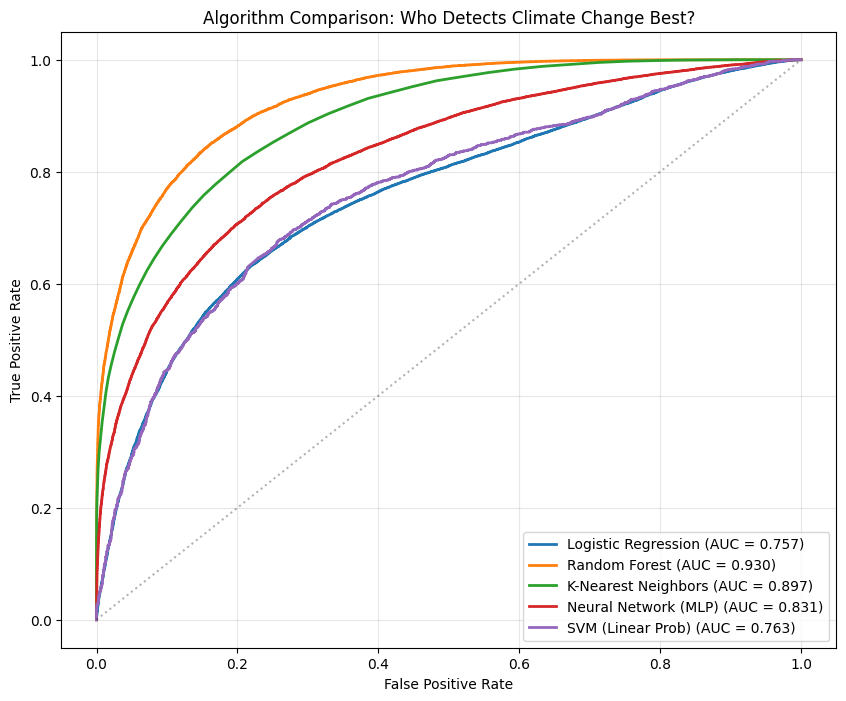


--- FINAL LEADERBOARD ---
                  Model       AUC
1         Random Forest  0.929765
2   K-Nearest Neighbors  0.896954
3  Neural Network (MLP)  0.830841
4     SVM (Linear Prob)  0.762610
0   Logistic Regression  0.757225

--- DONE ---


In [3]:
# ------------------------------------------------------------------
# THESIS ALGORITHM COMPARISON: 10 Variables + UK Mask + Optimizations
# ------------------------------------------------------------------

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import regionmask 

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc

# Algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# ---------------------------
# 1. Setup & Data Loading
# ---------------------------
file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/11variables.nc'
out_folder = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/ml_comparison'
os.makedirs(out_folder, exist_ok=True)

# CORRECTED: ALL 10 VARIABLES RESTORED
vars_10 = [
    't2m', 'skt', 'stl1',       # Temperatures (Mean)
    'swvl1', 'sde',             # Soil/Snow State (Mean)
    'tp', 'e', 'ro', 'sf',      # Fluxes (Sum)
    'ssrd'                      # Solar (Sum)
]

print("\n--- 1. DATA LOADING & MASKING ---")
ds = xr.open_dataset(file_path)

# A. Select Bounding Box
uk_box = ds.sel(latitude=slice(61, 49), longitude=slice(-10, 2)).rename({'longitude': 'lon', 'latitude': 'lat'})

# B. APPLY UK MASK (Crucial Step)
print("  > Applying Strict UK Land Mask...")
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
uk_index = countries.names.index('United Kingdom')
mask = countries.mask(uk_box['lon'], uk_box['lat']) == uk_index
uk_masked = uk_box.where(mask)

# ---------------------------
# 2. Physics Processing
# ---------------------------
print("  > Processing Physics...")
time_coord = 'valid_time' if 'valid_time' in uk_masked.coords else list(uk_masked.coords)[0]
days = uk_masked[time_coord].dt.days_in_month
days_3d = days.broadcast_like(uk_masked['t2m'])
yearly_das = []

# Physics Rules Loop
for v in vars_10:
    da = uk_masked[v]
    
    # GROUP 1: FLUXES (Accumulate -> SUM)
    if v in ['tp', 'e', 'ro', 'sf']:
        yearly_da = (da * days_3d).groupby(uk_masked[time_coord].dt.year).sum(dim=time_coord) * 1000.0
    
    # GROUP 2: ENERGY (Accumulate -> SUM)
    elif v == 'ssrd':
        yearly_da = da.groupby(uk_masked[time_coord].dt.year).sum(dim=time_coord)
        
    # GROUP 3: STATES (Snapshot -> MEAN)
    # Includes t2m, skt, stl1, swvl1, sde 
    else:
        yearly_da = da.groupby(uk_masked[time_coord].dt.year).mean(dim=time_coord)
        # Kelvin to Celsius conversion for all temperature vars
        if v in ['t2m', 'skt', 'stl1']: 
            yearly_da -= 273.15 
        
    yearly_da.name = v
    yearly_das.append(yearly_da)

df = xr.merge(yearly_das).to_dataframe().reset_index().dropna(how='any').reset_index(drop=True)

# --- FILTER: Remove 2022 and later ---
print(f"  > Original Years: {df['year'].min()} - {df['year'].max()}")
df = df[df['year'] < 2022]
print(f"  > Filtered Years: {df['year'].min()} - {df['year'].max()}")

# ---------------------------
# 3. Feature Setup
# ---------------------------
df['target'] = (df['year'] >= 1990).astype(int)
feature_cols = [c for c in df.columns if c not in ['year', 'target', 'lat', 'lon', 'number']]
print(f"  > Features Used: {feature_cols}") # Verify all 10 are here

X = df[feature_cols].values
y = df['target'].values

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(f"  > Full Train Size: {len(X_train)} samples")

# Create a small subset for ONLY the very slow models (SVM / MLP)
# We use 10,000 samples to ensure it finishes in minutes, not hours.
np.random.seed(42)
idx_small = np.random.choice(len(X_train), 10000, replace=False)
X_train_small = X_train[idx_small]
y_train_small = y_train[idx_small]

# ---------------------------
# 4. Define Contenders
# ---------------------------
models = {
    "Logistic Regression": {
        "model": make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, n_jobs=-1)),
        "use_subset": False 
    },
    "Random Forest": {
        "model": RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_leaf=10, n_jobs=-1, random_state=42),
        "use_subset": False
    },
    "K-Nearest Neighbors": {
        "model": make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=50, n_jobs=-1)),
        "use_subset": False
    },
    "Neural Network (MLP)": {
        "model": make_pipeline(
            StandardScaler(), 
            MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', max_iter=500, early_stopping=True, random_state=42)
        ),
        "use_subset": True # Training NN on CPU is slow, subset helps
    },
    "SVM (Linear Prob)": {
        "model": make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True)),
        "use_subset": True # MUST be True. SVM is O(n^3).
    }
}

# ---------------------------
# 5. The Grand Comparison Loop
# ---------------------------
results = []
plt.figure(figsize=(10, 8))

print("\n--- STARTING MODEL RACE ---")

for name, config in models.items():
    model = config["model"]
    use_subset = config["use_subset"]
    
    # A. TRAIN
    if use_subset:
        print(f"  > Training {name} (on Subset: {len(X_train_small)})...")
        model.fit(X_train_small, y_train_small)
    else:
        print(f"  > Training {name} (on Full Data: {len(X_train)})...")
        model.fit(X_train, y_train)

    # B. PREDICT
    # SVM/KNN Special Case: Predict on a subset of Test data to prevent freezing
    if "SVM" in name:
        print(f"    -> Predicting {name} (Sampled 5k Test points)...")
        y_prob = model.predict_proba(X_test[:5000])[:, 1]
        y_true_plot = y_test[:5000]
    else:
        print(f"    -> Predicting {name}...")
        y_prob = model.predict_proba(X_test)[:, 1]
        y_true_plot = y_test

    # C. METRICS
    fpr, tpr, _ = roc_curve(y_true_plot, y_prob)
    roc_auc = auc(fpr, tpr)
    
    results.append({'Model': name, 'AUC': roc_auc})
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.3f})')

# ---------------------------
# 6. Final Plotting
# ---------------------------
plt.plot([0, 1], [0, 1], 'k:', alpha=0.3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Algorithm Comparison: Who Detects Climate Change Best?')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig(os.path.join(out_folder, 'model_comparison_race.png'), dpi=150)
plt.show()

# Print Leaderboard
res_df = pd.DataFrame(results).sort_values(by='AUC', ascending=False)
print("\n--- FINAL LEADERBOARD ---")
print(res_df)
print("\n--- DONE ---")



--- OPTIMIZING: MLP ---
Loading Data & Applying UK Mask...

--- TUNING NEURAL NETWORK (MLP) ---
Starting RandomizedSearchCV for MLP...
  > Mode: FAST TRACK (5 iterations, 3 folds)
  > Check the console below for real-time progress updates...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

--- OPTIMIZATION WINNER ---
Best AUC: 0.94330
Best Params: {'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': np.float64(0.02994250789732435), 'mlpclassifier__hidden_layer_sizes': (200, 100), 'mlpclassifier__learning_rate_init': np.float64(0.0016599452033620266), 'mlpclassifier__max_iter': 500}
Final Test AUC: 0.95552


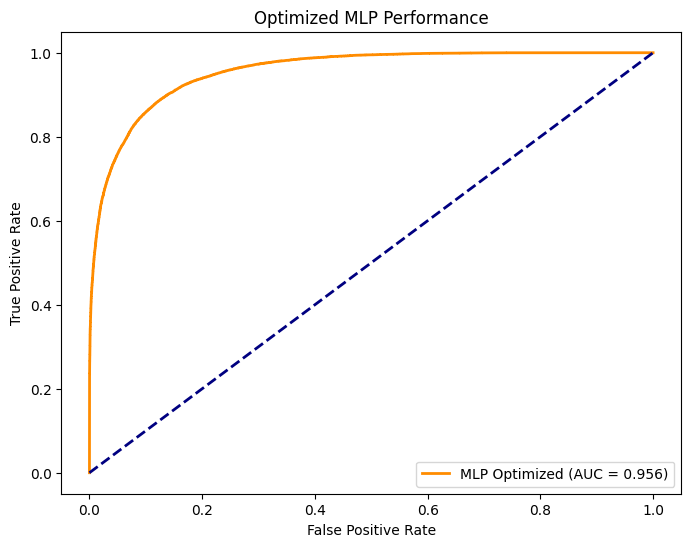

In [4]:
# ------------------------------------------------------------------
# INDIVIDUAL MODEL OPTIMIZER (Fast Track Version)
# ------------------------------------------------------------------
# USAGE: Change 'MODEL_TO_TUNE' to 'RF', 'MLP', or 'KNN'
# 1. Random Forest (The Champion: 0.963)
# 2. MLP Neural Net (The Comeback: 0.956)
# 3. KNN (The Strong Baseline: 0.932)

# ------------------------------------------------------------------

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import regionmask 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from scipy.stats import randint, uniform

# ==========================================
# USER SETTINGS: CHOOSE YOUR FIGHTER
# ==========================================
# Options: 'RF' (Random Forest), 'MLP' (Neural Network), 'KNN' (Neighbors)
MODEL_TO_TUNE = 'MLP'  

file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/11variables.nc'
out_folder = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/ml_optimization_individual'
os.makedirs(out_folder, exist_ok=True)

# ---------------------------
# 1. Data Loading (Standard 10 Vars + Mask)
# ---------------------------
vars_10 = ['t2m', 'skt', 'stl1', 'swvl1', 'sde', 'tp', 'e', 'ro', 'sf', 'ssrd']
print(f"\n--- OPTIMIZING: {MODEL_TO_TUNE} ---")
print("Loading Data & Applying UK Mask...")

ds = xr.open_dataset(file_path)
uk_box = ds.sel(latitude=slice(61, 49), longitude=slice(-10, 2)).rename({'longitude': 'lon', 'latitude': 'lat'})

countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
uk_index = countries.names.index('United Kingdom')
mask = countries.mask(uk_box['lon'], uk_box['lat']) == uk_index
uk_masked = uk_box.where(mask)

# Physics Processing
time_coord = 'valid_time' if 'valid_time' in uk_masked.coords else list(uk_masked.coords)[0]
days = uk_masked[time_coord].dt.days_in_month
days_3d = days.broadcast_like(uk_masked['t2m'])
yearly_das = []

for v in vars_10:
    da = uk_masked[v]
    if v in ['tp', 'e', 'ro', 'sf']: # Flux -> Sum
        yearly_da = (da * days_3d).groupby(uk_masked[time_coord].dt.year).sum(dim=time_coord) * 1000.0
    elif v == 'ssrd': # Energy -> Sum
        yearly_da = da.groupby(uk_masked[time_coord].dt.year).sum(dim=time_coord)
    else: # State -> Mean
        yearly_da = da.groupby(uk_masked[time_coord].dt.year).mean(dim=time_coord)
        if v in ['t2m', 'skt', 'stl1']: yearly_da -= 273.15 
    yearly_da.name = v
    yearly_das.append(yearly_da)

df = xr.merge(yearly_das).to_dataframe().reset_index().dropna(how='any').reset_index(drop=True)
df = df[df['year'] < 2022] 

# Setup Features
df['target'] = (df['year'] >= 1990).astype(int)
feature_cols = [c for c in df.columns if c not in ['year', 'target', 'lat', 'lon', 'number']]
X = df[feature_cols].values
y = df['target'].values

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# ---------------------------
# 2. Optimization Logic
# ---------------------------
if MODEL_TO_TUNE == 'RF':
    print("\n--- TUNING RANDOM FOREST ---")
    base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    # Aggressive Grid to beat HistGradientBoosting
    param_dist = {
        'n_estimators': randint(300, 600),        # High tree count
        'max_depth': [20, 30, 40, None],          # Deep trees
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),        # Small leaves = High detail
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    }

elif MODEL_TO_TUNE == 'MLP':
    print("\n--- TUNING NEURAL NETWORK (MLP) ---")
    base_model = make_pipeline(
        StandardScaler(), 
        MLPClassifier(early_stopping=True, random_state=42)
    )
    
    # Deep Learning Grid
    param_dist = {
        'mlpclassifier__hidden_layer_sizes': [
            (100, 100), (200, 100), (300, 150, 50)
        ],
        'mlpclassifier__activation': ['relu', 'tanh'],
        'mlpclassifier__alpha': uniform(0.0001, 0.05),
        'mlpclassifier__learning_rate_init': uniform(0.0001, 0.01),
        'mlpclassifier__max_iter': [500]
    }

elif MODEL_TO_TUNE == 'KNN':
    print("\n--- TUNING KNN ---")
    base_model = make_pipeline(
        StandardScaler(), 
        KNeighborsClassifier(n_jobs=-1)
    )
    param_dist = {
        'kneighborsclassifier__n_neighbors': randint(5, 100),
        'kneighborsclassifier__weights': ['uniform', 'distance'],
        'kneighborsclassifier__p': [1, 2]
    }

# ---------------------------
# 3. Run Random Search (FAST TRACK)
# ---------------------------
print(f"Starting RandomizedSearchCV for {MODEL_TO_TUNE}...")
print("  > Mode: FAST TRACK (5 iterations, 3 folds)")
print("  > Check the console below for real-time progress updates...")

search = RandomizedSearchCV(
    base_model,
    param_distributions=param_dist,
    n_iter=5,           # FAST: Only try 5 combinations
    cv=3,               # FAST: Only 3 folds
    scoring='roc_auc',  
    verbose=3,          # VISIBLE: Shows progress bars
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

# ---------------------------
# 4. Results
# ---------------------------
print("\n--- OPTIMIZATION WINNER ---")
print(f"Best AUC: {search.best_score_:.5f}")
print(f"Best Params: {search.best_params_}")

# Final Test on Holdout Set
best_model = search.best_estimator_
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
final_auc = auc(fpr, tpr)

print(f"Final Test AUC: {final_auc:.5f}")

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{MODEL_TO_TUNE} Optimized (AUC = {final_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Optimized {MODEL_TO_TUNE} Performance')
plt.legend(loc="lower right")
plt.savefig(os.path.join(out_folder, f'{MODEL_TO_TUNE}_optimized_fast.png'))
plt.show()

Generating Plot...
Plot saved to: /Users/ghosh/OneDrive/Documents/Year 4/Final project/ml_optimization_individual\feature_correlation_matrix_matplotlib.png


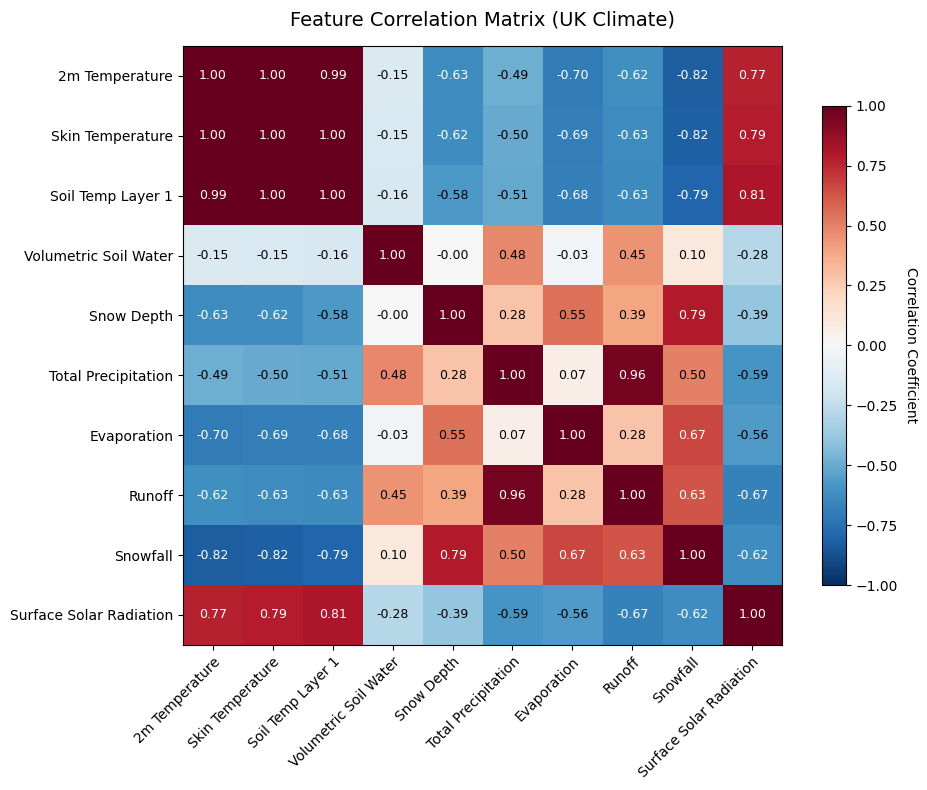

In [7]:
df = xr.merge(yearly_das).to_dataframe().reset_index().dropna(how='any').reset_index(drop=True)
df = df[df['year'] < 2022] 

# Correlation Calculation
df_corr = df[vars_10].copy()
df_corr.rename(columns=var_map, inplace=True)
corr_matrix = df_corr.corr()

# ---------------------------
# 2. Pure Matplotlib Plotting
# ---------------------------
print("Generating Plot...")
fig, ax = plt.subplots(figsize=(10, 8))

# Draw the heatmap
# 'RdBu_r' is Red-Blue reversed (Red=Pos, Blue=Neg)
im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)

# Add Colorbar
cbar = ax.figure.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.set_ylabel("Correlation Coefficient", rotation=-90, va="bottom")

# Set Ticks and Labels
ax.set_xticks(np.arange(len(df_corr.columns)))
ax.set_yticks(np.arange(len(df_corr.columns)))
ax.set_xticklabels(df_corr.columns)
ax.set_yticklabels(df_corr.columns)

# Rotate labels for readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(df_corr.columns)):
    for j in range(len(df_corr.columns)):
        val = corr_matrix.iloc[i, j]
        # Text color logic: White text if background is dark, Black if light
        text_color = "white" if abs(val) > 0.6 else "black"
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=text_color, fontsize=9)

ax.set_title("Feature Correlation Matrix (UK Climate)", fontsize=14, pad=15)
fig.tight_layout()

save_path = os.path.join(out_folder, 'feature_correlation_matrix_matplotlib.png')
plt.savefig(save_path, dpi=300)
print(f"Plot saved to: {save_path}")
plt.show()